In [1]:
import nutpie
import pathlib
import arviz
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import posteriordb
import json
import cmdstanpy
import time
import fastprogress
import pandas as pd
import xarray as xr

In [2]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [3]:
# Install cmdstan if necessary...
#cmdstanpy.install_cmdstan()

In [4]:
db = posteriordb.PosteriorDatabase("../../posteriordb/posterior_database/")

In [5]:
def store_trace(storage, name, kind, tr):
    tr.to_netcdf(f"{storage}/{name}_{kind}.nc")
    ess = arviz.ess(tr)
    ess.to_netcdf(f"{storage}/{name}_{kind}_ess.nc")

In [13]:
n_tune = 300

In [14]:
def sample_nutpie(posterior, *, storage, n_chains=12, overwrite=True):
    if os.path.exists(f"{storage}/{name}_nutpie.nc") and not overwrite:
        return
    with open(posterior.data.file_path()) as file:
        data = json.load(file)
    code = posterior.model.code("stan")
    compiled = nutpie.compile_stan_model(data, code=code)
    start = time.time()
    tr = nutpie.sample(compiled, chains=n_chains, seed=1, progress_bar=False, draws=1000, tune=n_tune,
                       store_gradient=True, store_mass_matrix=True, store_unconstrained=True)
    end = time.time()
    tr.posterior.attrs["sampling_time"] = end - start
    store_trace(storage, posterior.name, "nutpie", tr)

def sample_stan(posterior, *, n_chains=12, storage, overwrite=False):
    if os.path.exists(f"{storage}/{name}_stan.nc") and not overwrite:
        return
    cmd_model = cmdstanpy.CmdStanModel(posterior.model.name, posterior.model.code_file_path("stan"))
    with open(posterior.data.file_path()) as file:
        data = json.load(file)
    start = time.time()
    trace = cmd_model.sample(data, chains=n_chains, save_warmup=True,
                             show_progress=False, seed=1, iter_warmup=n_tune, iter_sampling=1000)
    end = time.time()
    tr = arviz.from_cmdstanpy(trace, save_warmup=True)
    tr.posterior.attrs["sampling_time"] = end - start
    store_trace(storage, posterior.name, "stan", tr)

In [15]:
storage = f"/mnt/harddrives/data_labs/covadapt-paper/2022-11-07-model-zoo_{n_tune}_grad_init"

In [16]:
!mkdir -p {storage}

In [17]:
names = db.posterior_names()

traces_nutpie = []
traces_stan = []

ess_nutpie = []
ess_stan = []

times_nutpie = []
times_stan = []

model_names = []
failed_models = []
errors = []

for name in fastprogress.progress_bar(names):
    # Those models don't really converge, and they take *a long time*
    if "covid" in name:
        continue
    # Another slow one...
    if "hmm" in name:
        continue
    if "election88_full" in name:
        continue
    if "nn_rbm" in name:
        continue
    if "ldaK5" in name:
        continue
    if "prostate-logistic_regression_rhs" in name:
        continue

    # Strange error during compilation
    if "sir-sir" in name:
        continue

    try:
        sample_nutpie(db.posterior(name), storage=storage, overwrite=True)
        sample_stan(db.posterior(name), storage=storage, overwrite=False)
    except (ValueError, RuntimeError, IndexError) as error:
        #print(f"failure for model {name}: {error}")
        errors.append(error)
        failed_models.append(name)
    else:
        model_names.append(name)    

Worker thread failed: Could not send sample to controller thread


In [12]:
len(errors)

4

In [13]:
# at 67

In [14]:
#model 17 is interesting

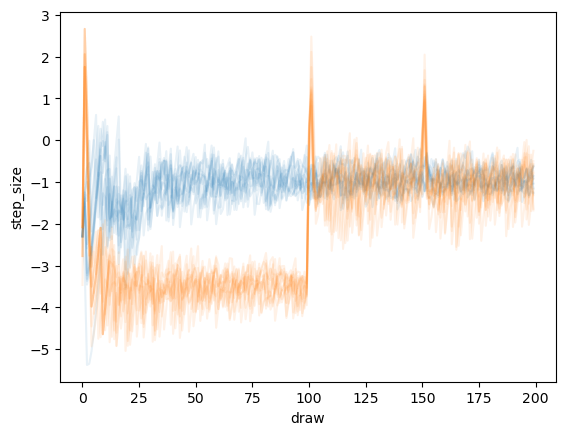

In [58]:
idx = 2
tr_nutpie = arviz.from_netcdf(f"{storage}/{model_names[idx]}_nutpie.nc")
tr_stan = arviz.from_netcdf(f"{storage}/{model_names[idx]}_stan.nc")

np.log(tr_nutpie.warmup_sample_stats.step_size).plot.line(x="draw", color="C0", alpha=0.1, add_legend=False)
np.log(tr_stan.warmup_sample_stats.step_size).plot.line(x="draw", color="C1", alpha=0.1, add_legend=False)
